**Importing the Required Modules**

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import rel_entr

from sklearn.linear_model import  Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

# 1 Generation Training and Production Data

## 1.1 Generation Data

In [63]:
# Generate a random regression dataset with 5000 samples and 5 features
X, y = make_regression(n_samples=5000, n_features=5, n_informative = 4, noise =5, random_state=42)

# Create datasets with different distribution for the input features
# Simulate a change in the first, third and last feature of the X dataset by adding random noise
X_mod = np.copy(X)
X_mod[:, 0] += np.random.normal(loc=0, scale=5, size=X.shape[0])
X_mod[:, 2] += np.random.normal(loc=3, scale=1.5, size=X.shape[0])
X_mod[:, 4] += np.random.normal(loc=-1, scale=.9, size=X.shape[0])

## 1.2 Data Visualization

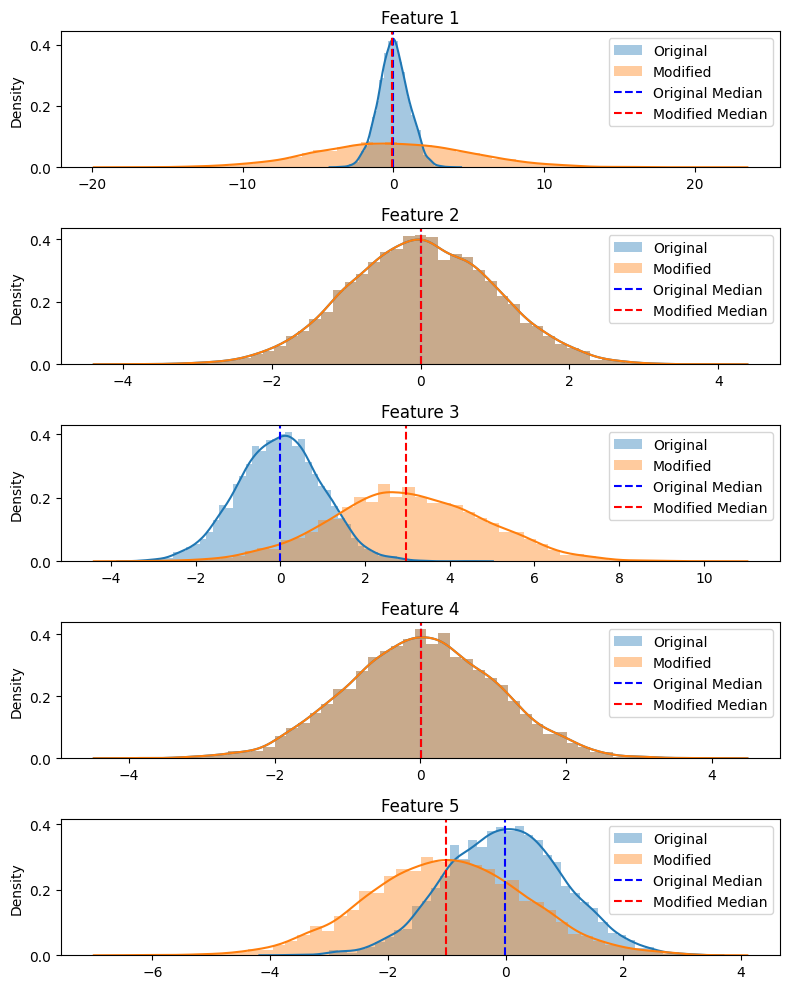

In [64]:
# Plot the distributions of all features for the original dataset and the modified dataset
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8,10))

for i, ax in enumerate(axs.flatten()):
    sns.distplot(X[:,i],  kde=True, label="Original", ax=ax)
    sns.distplot(X_mod[:,i], kde=True, label="Modified", ax=ax)
    ax.axvline(np.median(X[:,i]), color="blue", linestyle="--", label="Original Median")
    ax.axvline(np.median(X_mod[:,i]), color="red", linestyle="--", label="Modified Median")
    ax.set_title(f"Feature {i + 1}")
    ax.legend()

plt.tight_layout()

# 2 Regression Model Fitting and Metrics Evaluations

## 2.1 Regression Metrics Report

In [65]:
def regression_metrics_report(y_pred, y):
  
  k = X.shape[1]
  n = len(X)

  errors = abs(y_pred - y)
  RMSE = float(format(np.sqrt(mean_squared_error(y_pred, y)), ".3f"))
  MSE = mean_squared_error(y, y_pred)
  R2 = r2_score(y, y_pred, multioutput="variance_weighted")
  adjR2 = 1 - ((1 - R2)*(n - 1))/(n - k - 1)

  print(f"Average absolute error: {np.mean(errors):.3f}")
  print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}" )
  print(f"Mean Squared Error (MSE): {MSE:.3f}")
  print(f"R2_Score: {R2:.3f}")
  print(f"Adjusted R2: {adjR2:.3f}")

## 2.2 Model Fitting

In [66]:
lr_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=2.0))
lr_pipeline = lr_pipeline.fit(X, y)
y_pred = lr_pipeline.predict(X)

regression_metrics_report(y_pred, y)


Average absolute error: 4.000
Root Mean Squared Error (RMSE): 4.995
Mean Squared Error (MSE): 24.951
R2_Score: 0.999
Adjusted R2: 0.999


## 2.3 The Model Quality Testing on Production Data

In [67]:
y_prod = lr_pipeline.predict(X_mod)
regression_metrics_report(y_prod, y)

Average absolute error: 445.859
Root Mean Squared Error (RMSE): 560.175
Mean Squared Error (MSE): 313795.763
R2_Score: -14.649
Adjusted R2: -14.665


As you can see, the quality of the model's predictions on production data is very different from the predictions on the data on which it was trained. To automatize the detection of such situations, it is a good idea to automate the process of detecting them using py test.

# 3. Data Drift Detection

## 3.1 Data Drift Score 

To estimate the shift in the data, we will use a simple function based on the estimation of the Kullback-Leibler divergence $${\displaystyle D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\log \left({\frac {P(x)}{Q(x)}}\right)}$$

Using KL divergence may be justified to detect data shift specifically when we don't have target labels.

In [68]:
def drift_score(query_data, target_data, n_bins=40, eps=1e-6):
    query_hist, _ = np.histogram(query_data, bins=n_bins, density=True)
    query_hist += eps
    target_hist, _ = np.histogram(target_data, bins=n_bins, density=True)
    target_hist += eps
    etrops = rel_entr(target_hist, query_hist)
    return sum(abs(etrops))


In [69]:
print(f"estimating the shift of data relative to itself KL {drift_score(X, X)}")
print(f"estimating the shift of data relative to modified KL {drift_score(X, X_mod)}")

estimating the shift of data relative to itself KL 0.0
estimating the shift of data relative to modified KL 1.3213989119896064


Per feature data shift score:

In [70]:
n_features = X.shape[1]
for idx in range(n_features):
    print(f"Feature {idx} KL diffs {drift_score(X[:,idx], X_mod[:,idx])}")

Feature 0 KL diffs 1.6459570005036257
Feature 1 KL diffs 0.0
Feature 2 KL diffs 1.777935002577425
Feature 3 KL diffs 0.0
Feature 4 KL diffs 1.4105450211455832


As you can see, we can detect data shift for individual features

## 3.2 Data Serialization

In [71]:
#Predictions and targets 
np.savetxt("targets.csv", y, delimiter=",")
np.savetxt("predicts.csv", y_pred, delimiter=",")
np.savetxt("predicts_mod.csv", y_prod, delimiter=",")

#Initial Data and Product Data
np.savetxt("initial_data.csv", X, delimiter=",")
np.savetxt("product_data.csv", X_mod, delimiter=",")

## 3.3 PyTests for Data Shift Detection

### 3.3.1 Testing Inital Data

In [72]:
%%writefile test_initial_data.py
import pytest
import numpy as np
from scipy.special import rel_entr
from sklearn.metrics import mean_squared_error, r2_score

ACCEPTABLE_R2 = .85
ACCEPTABLE_RMSE = 6
ACCEPTABLE_DATA_DIVERGENCE = .5

def drift_score(query_data, target_data, n_bins=40, eps=1e-6):
    query_hist, _ = np.histogram(query_data, bins=n_bins, density=True)
    query_hist += eps
    target_hist,_ = np.histogram(target_data, bins=n_bins, density=True)
    target_hist += eps
    etrops = rel_entr(target_hist, query_hist)
    return sum(abs(etrops))

@pytest.fixture()
def load_targets():
   return np.loadtxt("targets.csv", delimiter=",")

@pytest.fixture()
def load_predictions():
   return np.loadtxt("predicts.csv", delimiter=",")

@pytest.fixture()
def load_data():
   return np.loadtxt("initial_data.csv", delimiter=",")

def test_rmse(load_targets, load_predictions):
   assert np.sqrt(mean_squared_error(load_targets, load_predictions)) < ACCEPTABLE_RMSE

def test_r2score(load_targets, load_predictions):
   assert r2_score(load_targets, load_predictions) >= ACCEPTABLE_R2

def test_kl_divergence(load_data): 
   assert drift_score(load_data, load_data) < ACCEPTABLE_DATA_DIVERGENCE

Overwriting test_initial_data.py


In [73]:
!pytest -v test_initial_data.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.0.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-3.6.2
collected 3 items                                                              

test_initial_data.py::test_rmse PASSED                                   [ 33%]
test_initial_data.py::test_r2score PASSED                                [ 66%]
test_initial_data.py::test_kl_divergence PASSED                          [100%]

============================== 3 passed in 2.40s ===============================


### 3.3.2 Testing Product Data and Data Shift Localization

In [74]:
%%writefile test_product_data.py
import pytest
import numpy as np
from scipy.special import rel_entr
from sklearn.metrics import mean_squared_error, r2_score

ACCEPTABLE_R2 = .85
ACCEPTABLE_RMSE = 6
ACCEPTABLE_DATA_DIVERGENCE = .5

def drift_score(query_data, target_data, n_bins=40, eps=1e-6):
    query_hist, _ = np.histogram(query_data, bins=n_bins, density=True)
    query_hist += eps
    target_hist,_ = np.histogram(target_data, bins=n_bins, density=True)
    target_hist += eps
    etrops = rel_entr(target_hist, query_hist)
    return sum(abs(etrops))

@pytest.fixture()
def load_targets():
   return np.loadtxt("targets.csv", delimiter=",")

@pytest.fixture()
def load_product_predictions():
   return np.loadtxt("predicts_mod.csv", delimiter=",")

@pytest.fixture()
def load_data():
   return np.loadtxt("initial_data.csv", delimiter=",")

@pytest.fixture()
def load_product_data():
   return np.loadtxt("product_data.csv", delimiter=",")

def test_rmse(load_targets, load_product_predictions):
   assert np.sqrt(mean_squared_error(load_targets, load_product_predictions)) < ACCEPTABLE_RMSE

def test_r2score(load_targets, load_product_predictions):
   assert r2_score(load_targets, load_product_predictions) >= ACCEPTABLE_R2

def test_kl_divergence(load_data, load_product_data): 
   assert drift_score(load_data, load_product_data) < ACCEPTABLE_DATA_DIVERGENCE

#Test for shift localization 
def test_1st_feature_shift(load_data, load_product_data): 
   assert drift_score(load_data[:,0], load_product_data[:,0]) > ACCEPTABLE_DATA_DIVERGENCE

def test_2nd_feature_shift(load_data, load_product_data): 
   assert drift_score(load_data[:,1], load_product_data[:,1]) > ACCEPTABLE_DATA_DIVERGENCE

def test_3rd_feature_shift(load_data, load_product_data): 
   assert drift_score(load_data[:,2], load_product_data[:,2]) > ACCEPTABLE_DATA_DIVERGENCE

def test_4th_feature_shift(load_data, load_product_data): 
   assert drift_score(load_data[:,3], load_product_data[:,3]) > ACCEPTABLE_DATA_DIVERGENCE

def test_5th_feature_shift(load_data, load_product_data): 
   assert drift_score(load_data[:,4], load_product_data[:,4]) > ACCEPTABLE_DATA_DIVERGENCE




Overwriting test_product_data.py


In [75]:
!pytest -v test_product_data.py

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-7.2.2, pluggy-1.0.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content
plugins: anyio-3.6.2
collected 8 items                                                              

test_product_data.py::test_rmse FAILED                                   [ 12%]
test_product_data.py::test_r2score FAILED                                [ 25%]
test_product_data.py::test_kl_divergence FAILED                          [ 37%]
test_product_data.py::test_1st_feature_shift PASSED                      [ 50%]
test_product_data.py::test_2nd_feature_shift FAILED                      [ 62%]
test_product_data.py::test_3rd_feature_shift PASSED                      [ 75%]
test_product_data.py::test_4th_feature_shift FAILED                      [ 87%]
test_product_data.py::test_5th_feature_shift PASSED                      [100%]

=================================== FAILURES ========